## Use t-test
-----------------
- Regression, logistic regression, cluster analysis, statistical graphics, quantile regression
- compare two means or propotions

1. Unmatched t-test: independent samples
2. Matched t-test: dependency

### Assumptions
----------
1. Variances of two populations are equal 
2. T-test makes sense only if means make sense

### Alternatives
-----------
1. Wilcoxon test
2. Permutation test
3. Bootstrap


Import needed libraries and data

In [1]:
import numpy  as np, pandas as pd
import json,os, glob,re
from pprint      import pprint
from scipy.stats import ttest_1samp, ttest_ind, wilcoxon
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt

In [2]:
def analyze(param, file):
    """Extract significant information from the json file."""
    
    #<================================= Data ===============================>
    # read data
    with open(file) as f:
         data    = json.load(f) 

    # keys for json object
    subjects = list(data.keys())
    windows  = list(data[subjects[0]].keys())

    # information storage
    info_storage = {}
    for each in windows:
        info_storage[each] = [] # initialization with empty list


    # store info
    for window in windows:
        for subject in subjects:
            info_storage[window].append(data[subject][window])

    #<================================= Tests ================================>
    # do t-test
    ttest_values = []
    for window in windows:
        ttest_values.append(ttest_1samp(info_storage[window][:-1],0.333))

    # combine info
    avg_values = [ [k,v] for k, v in data['avg_all'].items() ]
    t_values   = np.asarray(ttest_values)
    p_values   = [float(i) for i in t_values[:,-1]]

    # correction
    p_adjusted = multipletests(p_values, method='bonferroni')[:2]
    p_adjusted_l = list(map(list, zip(*[ x.tolist() for x in p_adjusted])))

    # for ease of use - pandas DataFrame
    values     = np.concatenate((avg_values,t_values,p_adjusted_l), axis= 1)
    data       = pd.DataFrame(values) # pandas
    data.columns = ['window', 'accuracy', 't-statistic', 'pvalue','truthfulness', 'new_p']
    
    #<=========================== visualize ==================================>
    plt.clf()
    fig, ax = plt.subplots()

    # decide on time
    windows_val    = [y*2 for y in [x-100 for x in range(0,440,param[1])]]
    
    # average values
    vals           = [x[-1] for x in avg_values][:len(windows_val)]
    ax.plot(windows_val,vals)

    # p significance
    sig_index =  data[data['truthfulness'] == '1.0']['accuracy'].index.tolist()[:len(windows_val)]
    

    #print(windows_val)
    ax.plot([windows_val[x] for x in sig_index],[vals[x] for x in sig_index], \
             linestyle = 'none', color='r', marker='o')

    # show starting understanding and chance level
    ax.axvline(x=0, color='black', alpha=0.5, linestyle='--', label='end of baseline period')
    ax.axhline(y=0.33, color='red', alpha=0.5, label='chance level')

    ax.legend(loc='upper right')
    ax.set_title('Classification accuracies for window size of '+ str(param[0]) \
                  + ' with a shift of '+ str(param[1]) + ' ms')
    fig.savefig("/home/doren/Desktop/"+ 'avg_accuracy.png', bbox_inches='tight')
    plt.show()


In [3]:
def choose_from_options( list_options, replace_option = ""):
    """Printing options the easily for the user to use."""
    
    separator = "\n-------------------------------------------------------\n"
    
    for index in range(len(list_options)):
        print("["+str(index+1)+"] "+ list_options[index].replace( replace_option,""))
    
    choice  = int(input('Enter choice: '))
    print("\n")
    
    return choice-1

In [4]:
def choose( folder_list):
    """Choose the accuracies you want to work with."""
    
    
    # get directory you want to work with
    folder_num  = choose_from_options( folder_list)
    
    # get the file you want to work with
    folders =  glob.glob( folder_list[ folder_num] + "*/accuracy_results.json")
    subdir = choose_from_options( folders, folder_list[folder_num])
    
    # choose
    print("You chose this file for analysis: " + folders[subdir]+ ' .')
    response  = input('Do you want to continue?(Y/anything else)')
    
    if response not in ['Y','y']:
        return
    
    else:
        # find window and shift
        param = [int(x) for x in re.findall(r'\d+', (folders[subdir].replace(folder_list[folder_num],"")))]
        analyze(param, folders[subdir])

In [5]:
def run_all(folder_list):
    """Run all the information that is in each folder."""

    for each in folder_list:
        folders =  glob.glob(  each + "*/accuracy_results.json")
        for each_subdir in folders:
            param = [int(x) for x in re.findall(r'\d+', (each_subdir.replace(each,"")))]
            analyze(param, each_subdir)

<Figure size 432x288 with 0 Axes>

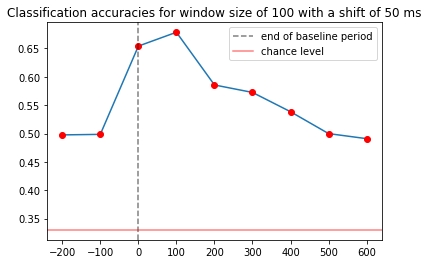

<Figure size 432x288 with 0 Axes>

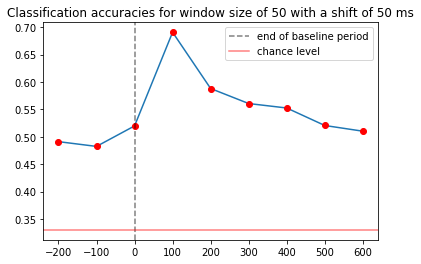

<Figure size 432x288 with 0 Axes>

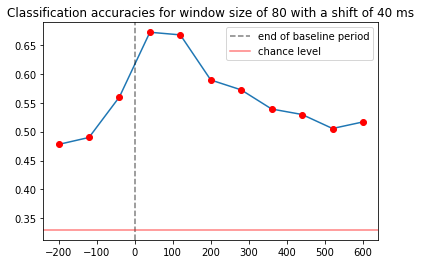

<Figure size 432x288 with 0 Axes>

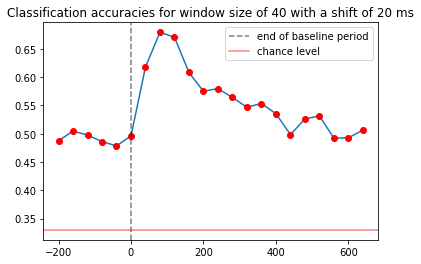

ValueError: x and y must have same first dimension, but have shapes (18,) and (17,)

<Figure size 432x288 with 0 Axes>

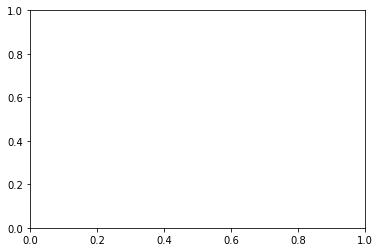

In [7]:
folder_list = [ "/home/doren/Desktop/CCN-ML/code/0_400_2/"] 
run_all(folder_list)